In [38]:
import pandas as pd
import re
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
df_unlabeled = pd.read_csv('../data/headlines.csv')  # Adjust path if needed
df_unlabeled['Date'] = pd.to_datetime(df_unlabeled['publish_date'], format='%Y%m%d', errors='coerce')
df_unlabeled = df_unlabeled[df_unlabeled['Date'].notna()]

In [10]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [39]:
df_unlabeled['Cleaned_Text'] = df_unlabeled['headline_text'].apply(clean_text)


In [40]:
# Load saved objects
with open('../models/tfidf.pkl', 'rb') as f:
    tfidf = pickle.load(f)

with open('../models/logistic_model.pkl', 'rb') as f:
    lr_model = pickle.load(f)


In [41]:
# Transform and predict
X_unlabeled_vec = tfidf.transform(df_unlabeled['Cleaned_Text'])
df_unlabeled['Predicted_Sentiment'] = lr_model.predict(X_unlabeled_vec)
df_unlabeled['Predicted_Sentiment_Label'] = df_unlabeled['Predicted_Sentiment'].map({0: 'Negative', 1: 'Positive', 2: 'Neutral'})


C:\Users\varad\AppData\Local\Temp\ipykernel_26120\2221335673.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_unlabeled, x='Predicted_Sentiment_Label', order=['Positive', 'Negative', 'Neutral'], palette='Set2')


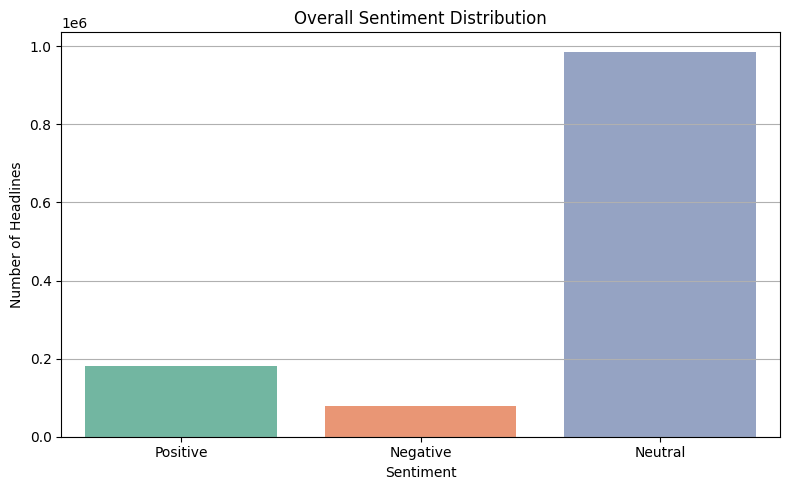

In [ ]:
# Bar Plot
plt.figure(figsize=(8, 5))
sns.countplot(data=df_unlabeled, x='Predicted_Sentiment_Label', order=['Positive', 'Negative', 'Neutral'], palette='Set2')
plt.title('Overall Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Headlines')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

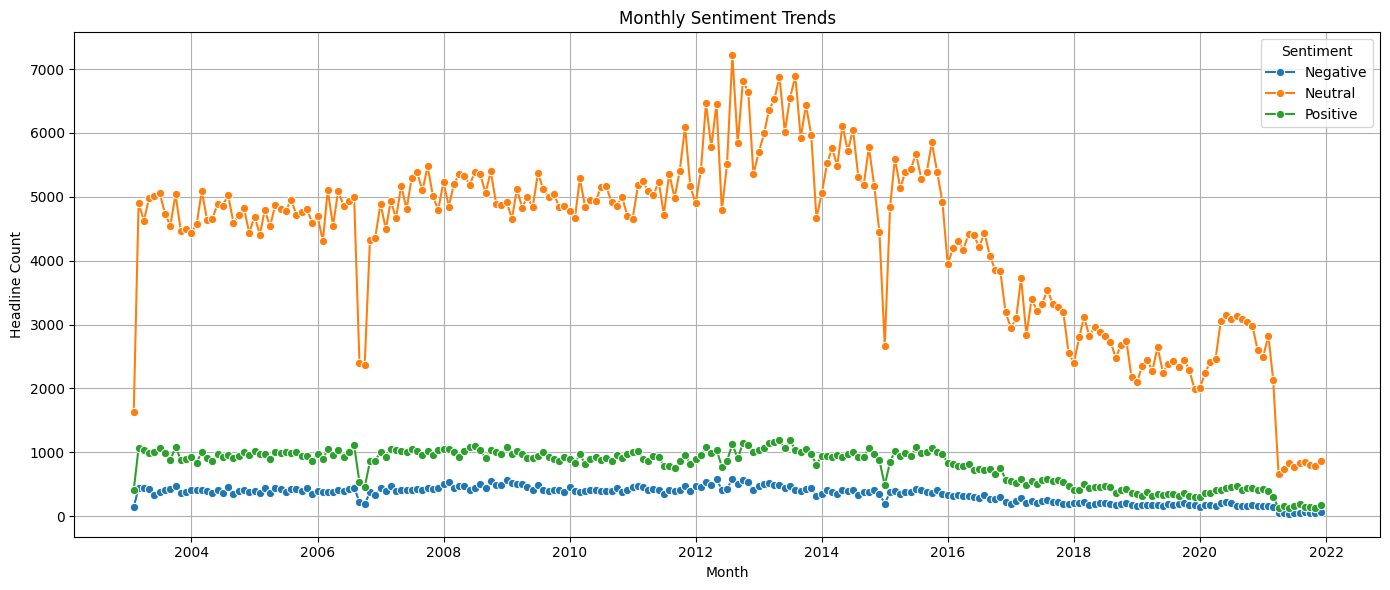

In [43]:
# Monthly Sentiment Trends (Line Plot)
# Convert to monthly timestamp
df_unlabeled['Month'] = df_unlabeled['Date'].dt.to_period('M').dt.to_timestamp()
monthly_counts = df_unlabeled.groupby(['Month', 'Predicted_Sentiment_Label']).size().reset_index(name='Count')

plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_counts, x='Month', y='Count', hue='Predicted_Sentiment_Label', marker='o')
plt.title('Monthly Sentiment Trends')
plt.xlabel('Month')
plt.ylabel('Headline Count')
plt.legend(title='Sentiment')
plt.grid(True)
plt.tight_layout()
plt.show()


0


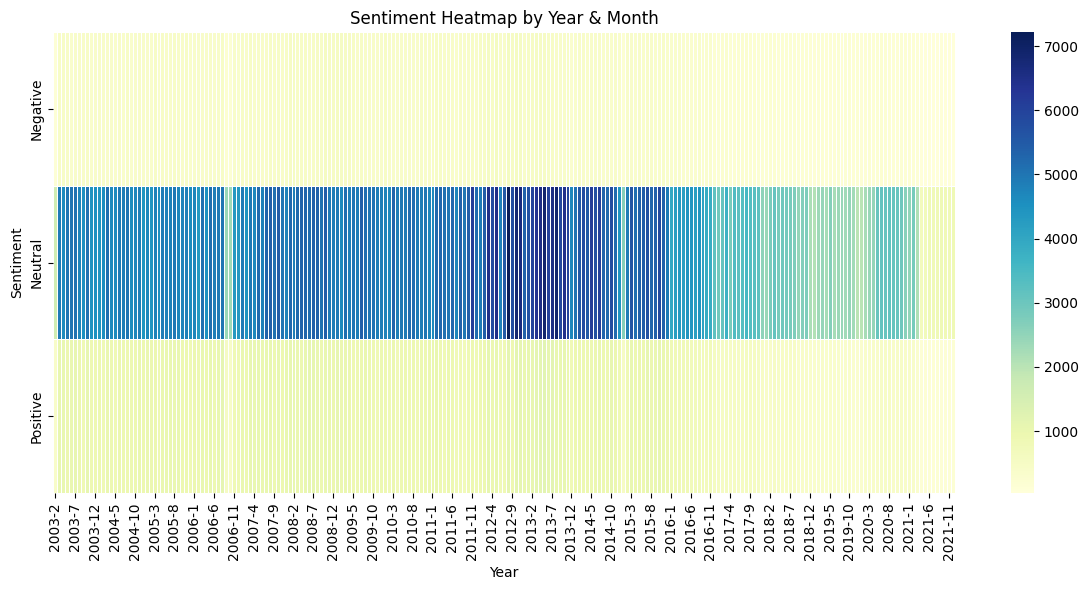

In [44]:
# 3. Heatmap of Sentiment Frequency by Year & Month
print(df_unlabeled['Date'].isna().sum())
df_unlabeled['Year'] = df_unlabeled['Date'].dt.year
df_unlabeled['Month_Num'] = df_unlabeled['Date'].dt.month
heatmap_data = df_unlabeled.groupby(['Year', 'Month_Num'])['Predicted_Sentiment_Label'].value_counts().unstack().fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data.T, cmap='YlGnBu', annot=False, linewidths=0.5)
plt.title('Sentiment Heatmap by Year & Month')
plt.xlabel('Year')
plt.ylabel('Sentiment')
plt.tight_layout()
plt.show()

In [46]:
df_unlabeled[['Date', 'headline_text', 'Predicted_Sentiment_Label']].to_csv('../outputs/headline_predictions.csv', index=False)